# COMPS II
### A notebook for producing paper-quality figures and captions for my upcoming COMPS-II paper.
##### Initialized by Drew Camron Sep 2018

In [1]:
%matplotlib inline
import os

import xarray as xr
import pandas as pd
import numpy as np

from pyresample import geometry, image

import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs

sns.set(context='poster', style='white')

In [2]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:43162 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 72 Cores: 72 Memory: 135.08 GB


In [3]:
indir_rcp = '/glade/p/cesm/pcwg_dev/jenkay/COSP/cesm112lens/runs_LENS_n16_cosp1.4_opaq_precboth/b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_agl_precboth_opaq/atm/proc/tseries/month_1/'
indir_1850 = '/glade/p/cesm/pcwg_dev/jenkay/COSP/cesm112lens/runs_LENS_n16_cosp1.4_opaq_precboth/b.e11.B1850LENS.f09_g16.001_cosp1.4_opaq_prec_agl_precboth_opaq/atm/proc/tseries/month_1/'
indir_obs = '/glade/work/mcamron/obs/cloudsat/tristan/'
indir_mask = '/glade/work/mcamron/gismask_RACMO23_0.9x1.25_con.nc'
indir_topo = '/glade/work/mcamron/USGS-gtopo30_0.9x1.25_remap_c051027.nc'

In [4]:
ds_vars = ['RADAR_LGTRAIN', 'RADAR_LGTRAINO', 'RADAR_RAIN', 'RADAR_RAINO', 'RADAR_LGTSNOW', 'RADAR_LGTSNOWO', 'RADAR_SNOW', 'RADAR_SNOWO']

fn_tseries_rcp = 'b.e11.BRCP85C5CNBDRD.f09_g16.001_cosp1.4_opaq_prec_agl_precboth_opaq.cam.h0.'
fn_tseries_1850 = 'b.e11.B1850LENS.f09_g16.001_cosp1.4_opaq_prec_agl_precboth_opaq.cam.h0.'
fext_tseries_rcp = '.200601-209512.nc'
fext_tseries_1850 = '.000101-010012.nc'

fnames_rcp = [indir_rcp + fn_tseries_rcp + var + fext_tseries_rcp for var in ds_vars]
fnames_1850 = [indir_1850 + fn_tseries_1850 + var + fext_tseries_1850 for var in ds_vars]

obs_ls = []
for yr in [('%02d' % a) for a in range(6, 17)]:
    for mo in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']:
        obs_ls = obs_ls + [indir_obs+file for file in os.listdir(indir_obs) if mo+yr in file]

ds_rcp = xr.open_mfdataset(fnames_rcp, decode_times=False).sel(lat=slice(0, 90))
newlons = [(lon - 360) if (lon > 179) else lon for lon in ds_rcp.lon.values]
ds_rcp = ds_rcp.assign_coords(lon=newlons).roll(lon=(ds_rcp.dims['lon'] // 2))
ds_1850 = xr.open_mfdataset(fnames_1850, decode_times=False).sel(lat=slice(0, 90))
ds_1850 = ds_1850.assign_coords(lon=newlons).roll(lon=(ds_1850.dims['lon'] // 2))
ds_obs = xr.open_mfdataset(obs_ls, concat_dim='time')

ds_rcp['time'] = pd.date_range('2006-01', '2095-12', freq='MS')
ds_1850['time'] = pd.date_range('2006-01', '2105-12', freq='MS')
ds_obs['time'] = pd.date_range('2006-06', '2016-05', freq='MS')

ds_obs['latitude'] = ds_obs['latitude'][0].reset_coords('time', drop=True)
ds_obs['longitude'] = ds_obs['longitude'][0].reset_coords('time', drop=True)
ds_obs = ds_obs.swap_dims({'nlats': 'latitude', 'nlons': 'longitude'}).sel(latitude=slice(0, 90))
#ds_obs = ds_obs.assign_coords(longitude=(ds_obs.longitude % 360)).roll(longitude=(ds_obs.dims['longitude'] // 2))

ds_mask = xr.open_dataset(indir_mask).sel(lat=slice(0, 90))
ds_mask = ds_mask.assign_coords(lon=newlons).roll(lon=(ds_mask.dims['lon'] // 2))
#ms = ds_mask['GrIS_mask'].where(ds_mask['GrIS_mask'] > 0)

ds_topo = xr.open_dataset(indir_topo).sel(lat=slice(0, 90))
ds_topo = ds_topo.assign_coords(lon=newlons).roll(lon=(ds_topo.dims['lon'] // 2))

In [5]:
ds_pres = ds_rcp.isel(time=slice(0, 180))
ds_fut = ds_rcp.isel(time=slice(-181, -1))

rain_pres = (
    ds_pres['RADAR_RAIN'] + ds_pres['RADAR_LGTRAIN']) / 100
snow_pres = (
    ds_pres['RADAR_SNOW'] + ds_pres['RADAR_LGTSNOW']) / 100

rain_fut = (
    ds_fut['RADAR_RAIN'] + ds_fut['RADAR_LGTRAIN']) / 100
snow_fut = (
    ds_fut['RADAR_SNOW'] + ds_fut['RADAR_LGTSNOW']) / 100

rain_obs = (
    (ds_obs['raincounts'] + #ds_obs['heavyraincounts'] +    # heavy rain is a subset of rain certain
     ds_obs['probablecounts'] + ds_obs['possiblecounts']) / ds_obs['counts'])
snow_obs = (
    (ds_obs['snowcounts'] + ds_obs['snowpossiblecounts']) / ds_obs['counts'])

---
## Figure 1
`CLOUDSAT` sum rain frequency and sum snow frequency maps, shown annually and seasonally.

In [6]:
list(np.linspace(0, 0.1, 5))

[0.0, 0.025, 0.05, 0.07500000000000001, 0.1]

/glade/u/home/mcamron/miniconda3/envs/cesm/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


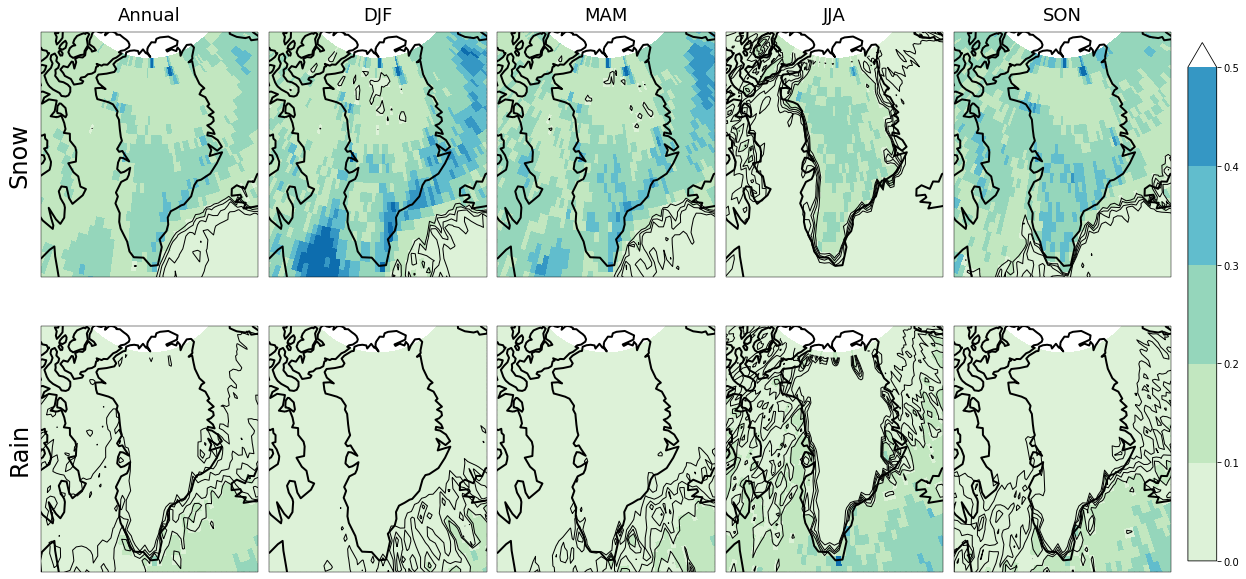

In [7]:
f, axes = plt.subplots(
            nrows=2, ncols=5, figsize=(16, 9),
            subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=315)}
            )

seasons = ['DJF', 'MAM', 'JJA', 'SON']
vm = 0.5

vm_lv = int(vm*10 + 1)
levels = list(np.linspace(0, vm, vm_lv))
con_lv = list(np.linspace(0, 0.1, 5))
colors = sns.color_palette('GnBu', vm_lv)

(snow_obs
 .mean('time')
 .plot.pcolormesh(
     ax=axes[0, 0], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
     levels=levels, colors=colors)
)

(snow_obs
 .mean('time')
 .plot.contour(
     ax=axes[0, 0], transform=ccrs.PlateCarree(), add_labels=False,
     levels=con_lv, linewidths=1, colors='k')
)


for i, x in enumerate(seasons):
    (snow_obs
    .groupby('time.season')
    .mean('time')
    .sel(season=x)
    .plot.pcolormesh(
        ax=axes[0, i+1], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
        levels=levels, colors=colors)
    )
    
    (snow_obs
     .groupby('time.season')
     .mean('time')
     .sel(season=x)
     .plot.contour(
         ax=axes[0, i+1], transform=ccrs.PlateCarree(),add_labels=False,
         levels=con_lv, linewidths=1, colors='k'))

p = (rain_obs
    .mean('time')
    .plot.pcolormesh(
        ax=axes[1, 0], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
        levels=levels, colors=colors)
    )

(rain_obs
 .mean('time')
 .plot.contour(
     ax=axes[1, 0], transform=ccrs.PlateCarree(),add_labels=False,
     levels=con_lv, linewidths=1, colors='k'))



for i, x in enumerate(seasons):
    (rain_obs
    .groupby('time.season')
    .mean('time')
    .sel(season=x)
    .plot.pcolormesh(
        ax=axes[1, i+1], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
        levels=levels, colors=colors)
    )
    
    (rain_obs
     .groupby('time.season')
     .mean('time')
     .sel(season=x)
     .plot.contour(ax=axes[1, i+1], transform=ccrs.PlateCarree(), add_labels=False,
                   levels=con_lv, linewidths=1, colors='k')
    )

    
for ax in axes.flat:
    ax.coastlines(linewidth=2)
    ax.set_extent([295, 335, 57, 84])

plt.tight_layout()
    
cb_ax = f.add_axes([1.005, 0.1, 0.025, 0.8])
cb = f.colorbar(p, cax=cb_ax, extend='max')
    
axes[0, 0].text(-0.1, 0.5, 'Snow', fontsize=24, 
                rotation='vertical', ha='center', va='center', transform=axes[0, 0].transAxes)
axes[1, 0].text(-0.1, 0.5, 'Rain', fontsize=24,
                rotation='vertical', ha='center', va='center', transform=axes[1, 0].transAxes)

for ax, xlab in zip(axes[0, :], ['Annual', 'DJF', 'MAM', 'JJA', 'SON']):
    ax.text(0.5, 1.03, xlab, fontsize=18, transform=ax.transAxes, ha='center', va='bottom')


f.savefig('../figures/comps2/Figure1_mapgrid-cloudsat.png',
         bbox_extra_artists=(axes[:, 0]), bbox_inches='tight')

---
## Figure 2
Greenland mean seasonal cycle separated by variable.

In [8]:
roi=10e6

w_in = np.tile((ds_rcp['gw']), [len(ds_rcp['lon']), 1]).T
w = w_in / w_in.sum() / 2

x, y = np.meshgrid((ds_mask['lon'].values.astype('float32')), ds_mask['lat'])
xx, yy = np.meshgrid(ds_obs['longitude'], ds_obs['latitude']) 

ms_grid = geometry.GridDefinition(lons=x, lats=y)
obs_grid = geometry.GridDefinition(lons=xx, lats=yy)

ms_image = image.ImageContainerNearest(image_data=ds_mask['GrIS_mask'].values, geo_def=ms_grid, radius_of_influence=roi)
obs_ms = ms_image.resample(obs_grid).image_data

w_image = image.ImageContainerNearest(image_data=w, geo_def=ms_grid, radius_of_influence=roi)
obs_w = w_image.resample(obs_grid).image_data

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:34306 remote=tcp://127.0.0.1:43162>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:34307 remote=tcp://127.0.0.1:43162>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:34308 remote=tcp://127.0.0.1:43162>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:34309 remote=tcp://127.0.0.1:43162>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:34310 remote=tcp://127.0.0.1:43162>


distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:34316 remote=tcp://127.0.0.1:43162>


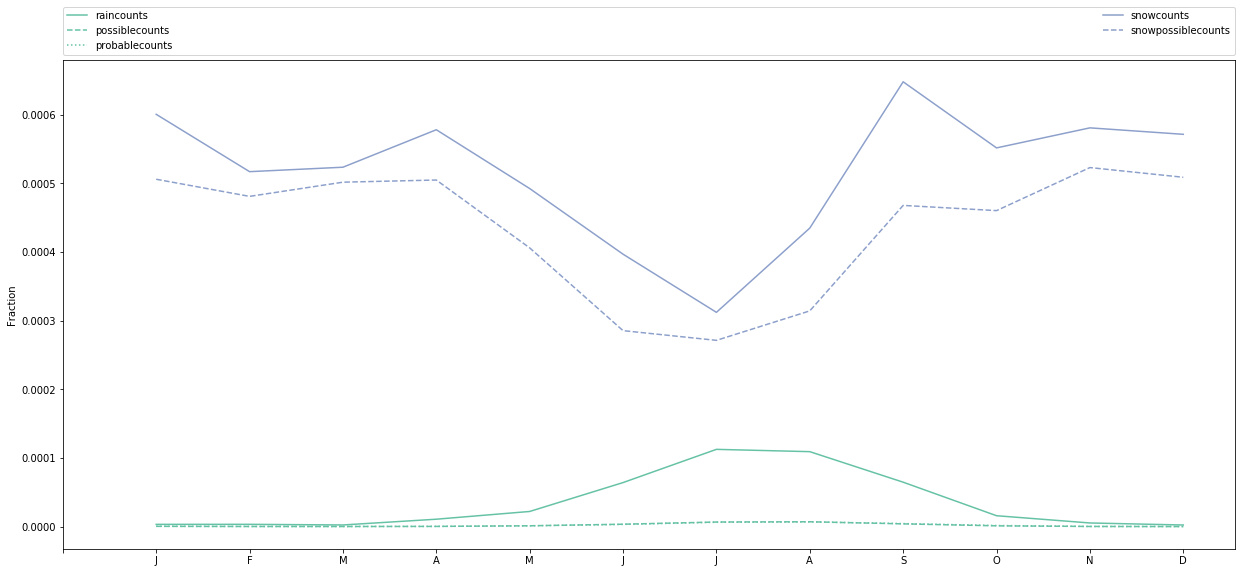

In [9]:
f, ax = plt.subplots(figsize=(21, 9))

obs_vars = ['raincounts', 'possiblecounts', 'probablecounts', 'snowcounts', 'snowpossiblecounts']
obs_lstyle = ['solid', 'dashed', 'dotted', 'solid', 'dashed']
obs_colors = [0, 0, 0, 2, 2]
for var, style, color in zip(obs_vars, obs_lstyle, obs_colors):
    ((((ds_obs[var] / ds_obs['counts']) * (obs_ms > 0) * obs_w).sum('latitude').sum('longitude'))
        .groupby('time.month').mean('time', skipna=True)
         .plot(ax=ax, label=var, color=sns.color_palette('Set2')[color], linestyle=style)
    )
    
ax.autoscale(enable=True)    

plt.xticks(np.arange(13), ['', 'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
ax.legend(bbox_to_anchor=(0., 1.01, 1., .101), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
ax.set_ylabel('Fraction')
ax.set_xlabel('')

f.savefig('../figures/comps2/Figure2_GIS-mean-cycle.png', bbox_inches='tight')

---
## Figure 3
Top: a distribution of precip frequencies by elevation. Bottom: distribution of total area of grids by elevation.

In [10]:
g = 9.80665
topo = ds_topo['PHIS'] / g

xxx, yyy = np.meshgrid(ds_topo['lon'], ds_topo['lat'])
topo_grid = geometry.GridDefinition(lons=xxx, lats=yyy)
topo_image = image.ImageContainerNearest(image_data=topo.values, geo_def=topo_grid, radius_of_influence=roi)
obs_topo_um = topo_image.resample(obs_grid).image_data

obs_topo = obs_topo_um * (obs_ms > 0)

In [53]:
(topo.values * (ds_mask['GrIS_mask'] > 0)[:-1, :].values).max(), obs_topo.max()

(3076.8285354879904, 3076.8285354879904)

Text(0,0.5,'Density')

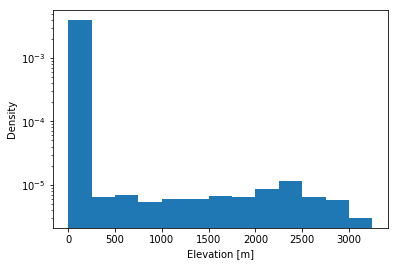

In [11]:
n, bins, patches = plt.hist(obs_topo.flatten(), bins=np.arange(0, obs_topo.max()+250, 250), density=True, log=True)
plt.xlabel('Elevation [m]')
plt.ylabel('Density')

In [12]:
snow_obs_val = snow_obs.values

In [13]:
avg_snow_elev_obs = np.zeros(bins.size)
obs_ms_time = np.broadcast_to((obs_ms > 0), snow_obs_val.shape)
for i, elev in enumerate(bins):
    if elev != bins[-1]:
        binmask = np.broadcast_to(((obs_topo >= elev) & (obs_topo < elev+250)), snow_obs_val.shape)
    else:
        binmask = np.broadcast_to(((obs_topo >= elev) & (obs_topo <= elev+250)), snow_obs_val.shape)
    avg_snow_elev_obs[i] = np.nanmean(binmask * snow_obs_val * obs_ms_time)

Text(0,0.5,'Mean snow frequency fraction')

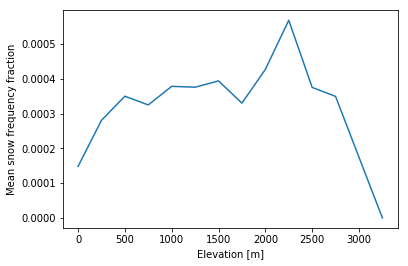

In [14]:
plt.plot(bins, avg_snow_elev_obs)
#plt.yscale('log')
plt.xlabel('Elevation [m]')
plt.ylabel('Mean snow frequency fraction')

---
## Figure 4
CESM 1 `present` bias maps relative to `CLOUDSAT` observations, ie as in **Figure 1** (CESM `present` - `CLOUDSAT`).

In [15]:
snow_pres_seasonal = snow_pres.groupby('time.season').mean('time').values
rain_pres_seasonal = rain_pres.groupby('time.season').mean('time').values

snow_pres_mean = np.zeros((4, ds_obs.dims['latitude'], ds_obs.dims['longitude']))
rain_pres_mean = np.zeros((4, ds_obs.dims['latitude'], ds_obs.dims['longitude']))

for i in range(0, 4):
    snow_pres_image = image.ImageContainerNearest(snow_pres_seasonal[i, :, :], geo_def=ms_grid, radius_of_influence=roi)
    snow_pres_mean[i] = snow_pres_image.resample(obs_grid).image_data

    rain_pres_image = image.ImageContainerNearest(rain_pres_seasonal[i, :, :], geo_def=ms_grid, radius_of_influence=roi)
    rain_pres_mean[i] = snow_pres_image.resample(obs_grid).image_data

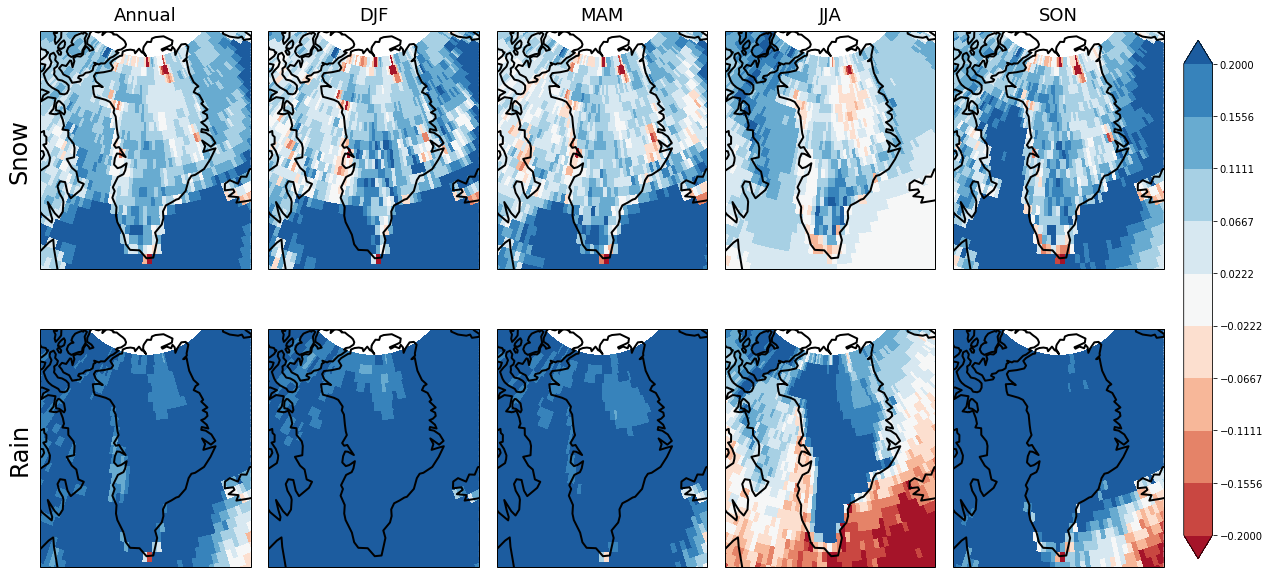

In [16]:
f, axes = plt.subplots(
            nrows=2, ncols=5, figsize=(16, 9),
            subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=315)}
            )

seasons = ['DJF', 'MAM', 'JJA', 'SON']
vm = 0.2

vmlv = 10
colv = vmlv+1
levels = list(np.linspace(-vm, vm, vmlv))
colors = sns.color_palette('RdBu', colv)

((snow_pres_mean - snow_obs.groupby('time.season').mean('time'))
 .mean('season')
 .plot.pcolormesh(
     ax=axes[0, 0], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
     levels=levels, colors=colors)
)

for i, x in enumerate(seasons):
    ((snow_pres_mean - snow_obs.groupby('time.season').mean('time'))
    .sel(season=x)
    .plot.pcolormesh(
        ax=axes[0, i+1], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
        levels=levels, colors=colors)
    )

p = ((rain_pres_mean - rain_obs.groupby('time.season').mean('time'))
     .mean('season')
     .plot.pcolormesh(
         ax=axes[1, 0], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
         levels=levels, colors=colors)
    )

for i, x in enumerate(seasons):
    ((rain_pres_mean - rain_obs.groupby('time.season').mean('time'))
    .sel(season=x)
    .plot.pcolormesh(
        ax=axes[1, i+1], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
        levels=levels, colors=colors)
    )

    
for ax in axes.flat:
    ax.coastlines(linewidth=2)
    ax.set_extent([295, 335, 57, 84])

plt.tight_layout()
    
cb_ax = f.add_axes([1.005, 0.1, 0.025, 0.8])
cb = f.colorbar(p, cax=cb_ax)#, extend='max')
    
axes[0, 0].text(-0.1, 0.5, 'Snow', fontsize=24, 
                rotation='vertical', ha='center', va='center', transform=axes[0, 0].transAxes)
axes[1, 0].text(-0.1, 0.5, 'Rain', fontsize=24,
                rotation='vertical', ha='center', va='center', transform=axes[1, 0].transAxes)

for ax, xlab in zip(axes[0, :], ['Annual', 'DJF', 'MAM', 'JJA', 'SON']):
    ax.text(0.5, 1.03, xlab, fontsize=18, transform=ax.transAxes, ha='center', va='bottom')


f.savefig('../figures/comps2/Figure4_mapgrid-cesm-pres.png',
         bbox_extra_artists=(axes[:, 0]), bbox_inches='tight')

---
## Figure 5
CESM 1 `present` mean seasonal cycle, ie as in **Figure 2**.

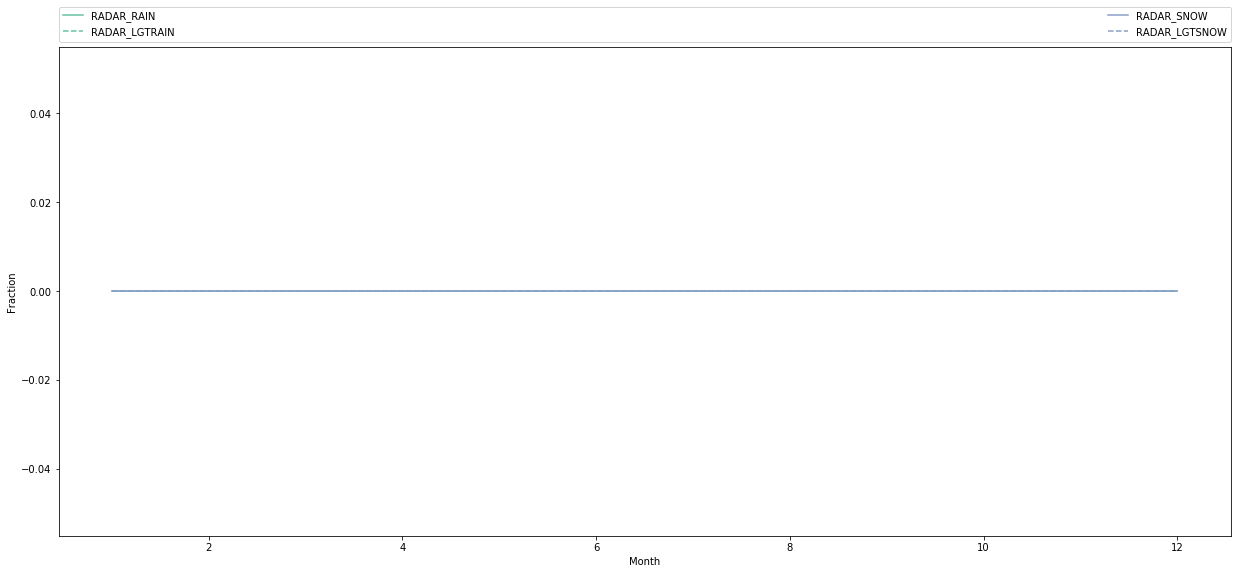

In [33]:
f, ax = plt.subplots(figsize=(21, 9))

model_vars = ['RADAR_RAIN', 'RADAR_LGTRAIN', 'RADAR_SNOW', 'RADAR_LGTSNOW']
model_lstyle = ['solid', 'dashed', 'solid', 'dashed']
model_colors = [0, 0, 2, 2]
for var, style, color in zip(model_vars, model_lstyle, model_colors):
    ((((ds_pres[var] * (ds_mask['GrIS_mask'] > 0)).mean('lon', skipna=True) * ds_rcp['gw']/2).sum('lat', skipna=True))
         .groupby('time.month').mean('time', skipna=True)
         .plot(ax=ax, label=var, color=sns.color_palette('Set2')[color], linestyle=style)
    )
    
ax.autoscale(enable=True)    

ax.legend(bbox_to_anchor=(0., 1.01, 1., .101), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
ax.set_ylabel('Fraction')
ax.set_xlabel('Month')

f.savefig('../figures/comps2/Figure5_GIS-mean-cycle.png', bbox_inches='tight')

---
## Supplemental

### Supp to Fig 4
Maps of CESM 1 `present` (non-bias).

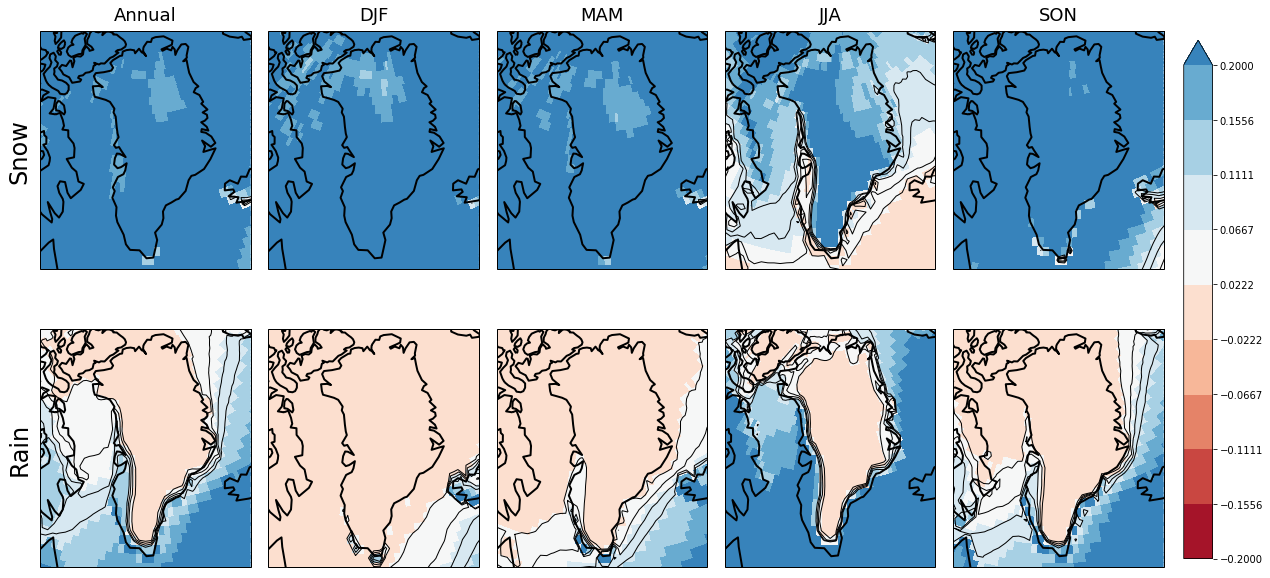

In [18]:
f, axes = plt.subplots(
            nrows=2, ncols=5, figsize=(16, 9),
            subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=315)}
            )

(snow_pres
 .mean('time')
 .plot.pcolormesh(
     ax=axes[0, 0], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
     levels=levels, colors=colors)
)

(snow_pres
 .mean('time')
 .plot.contour(
     ax=axes[0, 0], transform=ccrs.PlateCarree(), add_labels=False,
     levels=con_lv, linewidths=1, colors='k')
)

for i, x in enumerate(seasons):
    (snow_pres
    .groupby('time.season')
    .mean('time')
    .sel(season=x)
    .plot.pcolormesh(
        ax=axes[0, i+1], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
        levels=levels, colors=colors)
    )
    
    (snow_pres
     .groupby('time.season')
     .mean('time')
     .sel(season=x)
     .plot.contour(
         ax=axes[0, i+1], transform=ccrs.PlateCarree(), add_labels=False,
         levels=con_lv, linewidths=1, colors='k')
    )

p = (rain_pres
    .mean('time')
    .plot.pcolormesh(
        ax=axes[1, 0], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
        levels=levels, colors=colors)
    )

(rain_pres
 .mean('time')
 .plot.contour(
     ax=axes[1, 0], transform=ccrs.PlateCarree(), add_labels=False,
     levels=con_lv, linewidths=1, colors='k')
)

for i, x in enumerate(seasons):
    (rain_pres
    .groupby('time.season')
    .mean('time')
    .sel(season=x)
    .plot.pcolormesh(
        ax=axes[1, i+1], transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False,
        levels=levels, colors=colors)
    )
    
    (rain_pres
     .groupby('time.season')
     .mean('time')
     .sel(season=x)
     .plot.contour(
         ax=axes[1, i+1], transform=ccrs.PlateCarree(), add_labels=False,
         levels=con_lv, linewidths=1, colors='k')
    )

    
for ax in axes.flat:
    ax.coastlines(linewidth=2)
    ax.set_extent([295, 335, 57, 84])

plt.tight_layout()
    
cb_ax = f.add_axes([1.005, 0.1, 0.025, 0.8])
cb = f.colorbar(p, cax=cb_ax, extend='max')
    
axes[0, 0].text(-0.1, 0.5, 'Snow', fontsize=24, 
                rotation='vertical', ha='center', va='center', transform=axes[0, 0].transAxes)
axes[1, 0].text(-0.1, 0.5, 'Rain', fontsize=24,
                rotation='vertical', ha='center', va='center', transform=axes[1, 0].transAxes)

for ax, xlab in zip(axes[0, :], ['Annual', 'DJF', 'MAM', 'JJA', 'SON']):
    ax.text(0.5, 1.03, xlab, fontsize=18, transform=ax.transAxes, ha='center', va='bottom')


f.savefig('../figures/comps2/Supp_mapgrid-present.png',
         bbox_extra_artists=(axes[:, 0]), bbox_inches='tight')